#Data Story Project "London Underground data"

***

##Description and data sources

The current project aims to provide useful insights on usage of London tube and help Londoners to plan their journeys.
The project uses two data sets:

   ** 1. Oyster card data**
   
    This dataset provides a 5% sample of all Oyster card journeys performed in a week during November 2009 on bus, Tube, DLR and London Overground.
    
   ** 2. London Underground passenger counts data**
    
    Passenger counts collects information about passenger numbers entering and exiting London Underground stations, largely based on the Underground ticketing system gate data.
    
**Data source: "Transport for London" (https://api-portal.tfl.gov.uk/)**

***

##Loading modules

In [1]:
import pandas as pd
import numpy as np
import os

%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14, 'font.family': 'serif'})

import warnings
warnings.filterwarnings('ignore')

***

##Loading data

In [2]:
data_folder = 'C:\\data_science_intensive\\Data_story_project\\London Underground data'
os.chdir(data_folder)

***

### Importing Oyster card data

In [3]:
file_oyster = 'Nov09JnyExport.csv'
data_oyster = pd.read_csv(file_oyster)
len(data_oyster) #the data set contains 2623487 data entries

2623487

**Column descriptions**

- downo - a number between 1 and 7, 1 being Sunday, 2 being Monday etc
- daytype - Sun to Sat
- SubSystem - the mode(s) of the journey. LUL - London Underground, NR - National Rail, LTB - London Buses, DLR- Docklands Light - Railway, LRC - London Overground, TRAM - Croydon Tram
- StartStn - Station the journey started at
- EndStation - Station the journey ended at
- EntTime - Entry time of the journey in minutes after midnight
- EntTimeHHMM - Entry time in HH:MM text format
- ExTime - Exit time of the journey in minutes after midnight
- EXTimeHHMM - Exit time in HH:MM text format
- ZVPPT - zones of Oyster Season ticket, if used
- JNYTYP - Product types involved in the journey. PPY - Pure PAYG, TKT - Pure Oyster Season, MIXED - Combined PAYG and Oyster  Season
- DailyCapping - it shows as Y when PAYG journey was capped
- FFare - Full PAYG Fare before any discounts
- Dfare - PAYG Fare after usage based discounts
- RouteID - The Route Number of the Bus, if a Bus has been boarded
- FinalProduct - Combined Product Description used for journey

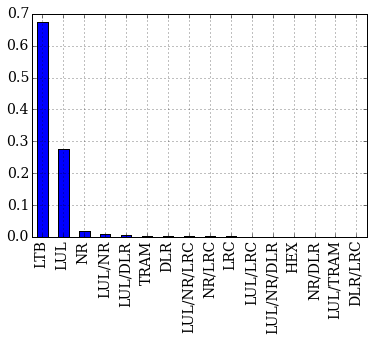

In [4]:
df_subsystems = (data_oyster.SubSystem).value_counts()/len(data_oyster)
df_subsystems.plot(kind = 'bar')

The majority of data entries are related to trips by London Buses (67%) and London Tube (28%)

In [5]:
#Bus
data_oyster_bus = data_oyster[data_oyster.SubSystem == 'LTB']
# Removing irrelevant columns (for example, there is no information on exit time of the journey if a Bus was used)
data_oyster_bus.drop(['StartStn','EndStation', 'ExTime', 'EXTimeHHMM', 'FFare', 'DFare'], axis=1, inplace=True)

In [6]:
#Tube
data_oyster_tube = data_oyster[data_oyster.SubSystem == 'LUL']

In [7]:
data_oyster_tube.StartStn.unique() #StartStn column contains 'Unstarted' values (20283 rows in total)
len(data_oyster_tube[data_oyster_tube.StartStn == 'Unstarted'])
data_oyster_tube = data_oyster_tube[data_oyster_tube.StartStn != 'Unstarted'] #removing rows that have no information of start stations

In [8]:
data_oyster_tube.EndStation.unique()
len(data_oyster_tube[data_oyster_tube.EndStation == 'Not Applicable']) #EndStation column contains 'Not Applicable' values (1 row)
data_oyster_tube = data_oyster_tube[(data_oyster_tube.EndStation != 'Not Applicable') & (data_oyster_tube.EndStation !='Unfinished')] #removing rows that have no information of end stations

***

### Importing London Underground passenger counts data

In [9]:
file_count_weekday = 'En 12Week.xls'
file_count_sat = 'En12sat.xls'
file_count_sun = 'En12sun.xls'

In [10]:
def read_xls_count_data(filename, Sheetname, ncolsskip):
    df = pd.read_excel(filename, Sheetname, skiprows = 6,skip_footer =2)
    df.drop(df.columns[-ncolsskip:], axis=1, inplace=True)
    df.drop(['nlc', 'Date', 'Note'], axis=1, inplace=True)
    df = df.set_index('Station')
    del df.index.name
    df['Total'] = df.sum(axis =1)
    return df

In [11]:
data_counts_week = read_xls_count_data(file_count_weekday, 'En Wk 12',7)
data_counts_sat = read_xls_count_data(file_count_sat, 'En SAT 2012',2)
data_counts_sun = read_xls_count_data(file_count_sun, 'En SUN 2012',2)

***

##Busiest stations 

###London Underground passenger counts data

What are the busiest stations? (Bar plots)

TypeError: f() got multiple values for keyword argument 'y'

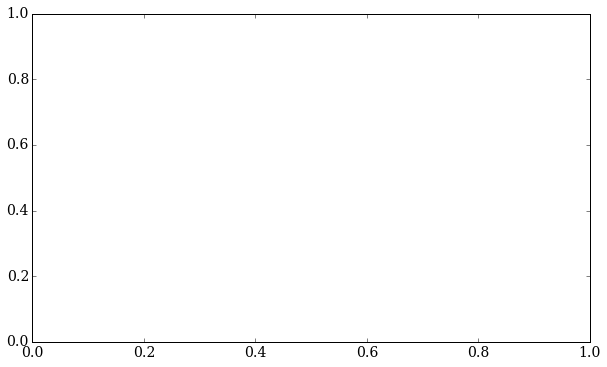

In [12]:
plt.figure(figsize = (10,20))
plt.subplot(311)
data_counts_week['Total'].order(ascending = False).head(20).plot(kind = 'bar', y = 'bla', color = 'black',title = 'Weekdays')
plt.subplot(312)
data_counts_sat['Total'].order(ascending = False).head(20).plot(kind = 'bar', color = 'black',title = 'Saturday')
plt.subplot(313)
data_counts_sun['Total'].order(ascending = False).head(20).plot(kind = 'bar', color = 'black',title = 'Sunday')
plt.tight_layout()

##Oyster card data

In [344]:
data_oyster_tube['DayType'] = data_oyster_tube.downo
data_oyster_tube['DayType'][data_oyster_tube.DayType == 1] = 'Sunday'
data_oyster_tube['DayType'][data_oyster_tube.DayType == 7] = 'Saturday'
data_oyster_tube['DayType'][(data_oyster_tube.DayType < 7) & (data_oyster_tube.DayType > 1)] = 'Weekdays'

In [345]:
df1 = data_oyster_tube[['DayType', 'StartStn']]
df1['Entry']= 1
df1 = df1.groupby(['DayType', 'StartStn']).count()

df2 = data_oyster_tube[['DayType', 'EndStation']]
df2['Exit']= 1
df2 = df2.groupby(['DayType', 'EndStation']).count()

In [346]:
data_oyster_tube_counts = pd.concat([df1, df2], axis=1)
data_oyster_tube_counts.fillna(0, inplace=True)

In [347]:
data_oyster_tube_counts['Total'] = data_oyster_tube_counts.sum(axis = 1)

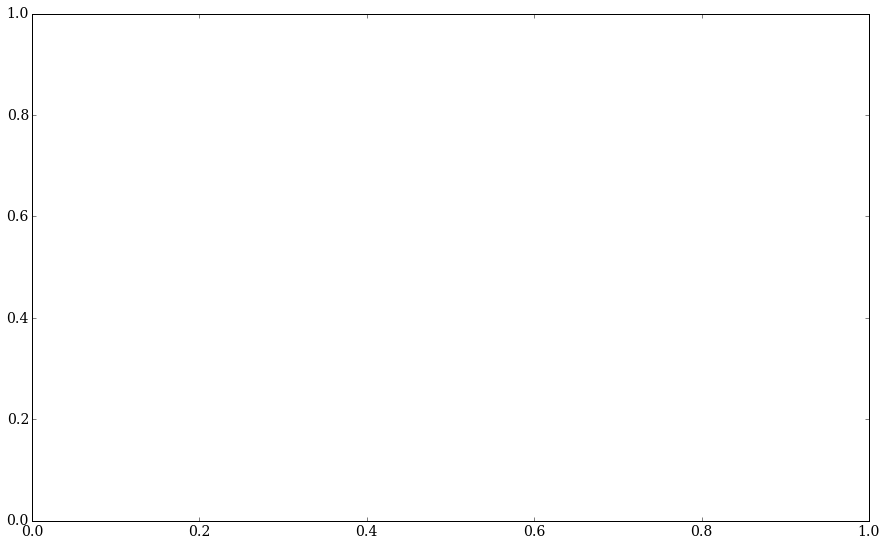

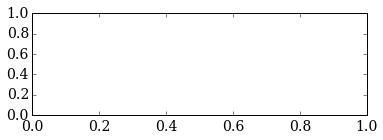

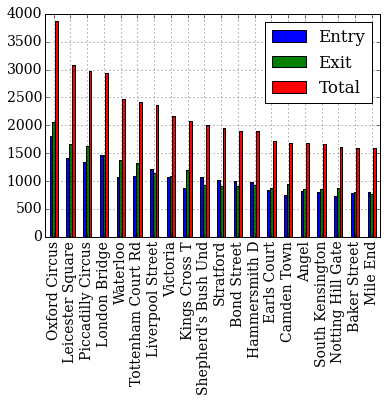

In [355]:
plt.figure(figsize = (15,20))
plt.subplot(211)
df = data_oyster_tube_counts.query('ilevel_0 == "Weekdays"').sort('Total', ascending = False).head(20).reset_index(level = 0, drop = True)
df.plot(kind = 'bar')
plt.subplot(212)
df1 = data_oyster_tube_counts.query('ilevel_0 == "Saturday"').sort('Total', ascending = False).head(20).reset_index(level = 0, drop = True)
df1.plot(kind = 'bar')

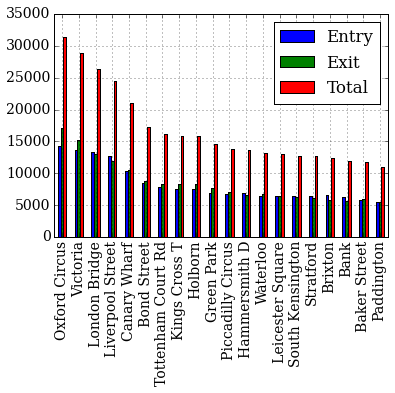

In [353]:
data_oyster_tube_counts.query('ilevel_0 == "Weekdays"').sort('Total', ascending = False).head(20).reset_index(level = 0, drop = True).plot(kind = 'bar')